In [ ]:
#!pip install opencv-python-headless


In [ ]:
#pip install --upgrade requests urllib3


In [ ]:
#pip install --upgrade certifi


In [ ]:
 # !pip install rasterio

In [ ]:
# !pip install torch torchvision torchaudio


In [ ]:
# !conda install -c conda-forge gdal --yes


In [ ]:
#import torch
#print("PyTorch version:", torch.__version__)
#print("CUDA available:", torch.cuda.is_available())


In [ ]:
# !pip install geopandas


In [ ]:
#!conda install -c conda-forge gdal --yes


In [ ]:
#import sys
#!{sys.executable} -m pip list | findstr GDAL


In [ ]:
# pip install PyDrive


In [ ]:
#from osgeo import gdal
#print("GDAL Version:", gdal.__version__)


# Landsat Collection 2 Surface Reflectance (Tier-1)
✅ What is it?
A pre-processed dataset with atmospheric corrections applied.

Ensures reliable reflectance values regardless of time of day, season, or weather conditions.

✅ Why use it?
Removes effects of clouds, haze, and sun angle.

Ensures consistency for multi-temporal analysis like glacier retreat.

## Tier-1
Highest quality scenes with accurate geolocation (error < 12 meters).
Suitable for time-series and change detection studies.

# .tif / .tiff – Tagged Image File Format
Full Form: Tagged Image File Format

Purpose: To store image data, especially high-resolution images with multiple layers (bands).

Geospatial Usage: When enhanced with geo-information, it becomes a GeoTIFF (a .tif file with embedded geographic metadata).

Significance:
Widely used for storing satellite imagery and raster maps.
Supports multiple bands and large file sizes.
Retains georeferencing data like coordinates and projection info.

# 🗺️ Geospatial Raster Dataset
Purpose: To represent real-world data (e.g., elevation, temperature, reflectance) as a grid of pixels.

Significance:
Each pixel holds a data value tied to a specific location.
Essential for remote sensing, climate analysis, land cover mapping, and glacier monitoring.
Examples: Satellite images, DEMs (Digital Elevation Models), NDVI maps.

# ⚙️ GDAL – Geospatial Data Abstraction Library
Full Form: Geospatial Data Abstraction Library

Purpose: A low-level open-source library for reading and writing geospatial raster and vector data formats.

Significance:
Supports over 100+ file formats like .tif, .shp, .geojson, .kml, etc.
Provides powerful tools for format conversion, coordinate transformation, raster operations, and more.
Foundation for tools like rasterio, QGIS, and Google Earth Engine.

# 🐍 rasterio – Python Library (built on GDAL)
Full Form: N/A (name of the Python package)

Purpose: Simplifies interaction with raster datasets in Python using GDAL under the hood.

Significance:

Allows reading, writing, plotting, and analyzing GeoTIFF and other raster data.
Provides access to:
Band values
Metadata (CRS, resolution, bounds)
Array-like access to pixel values for analysis

In [2]:
# geemap is the Python API of Google Earth Engine
import ee     #Python API for Google Earth Engine (GEE).
import geemap as geemap    #Python package built on GEE.
import torch
import rasterio
from torch.utils.data import Dataset, dataloader    # Enable custom data loading pipelines for training ML models.
from torchvision import transforms    # Useful for preprocessing image data (e.g., resizing, normalization).
import numpy as np
import matplotlib.pyplot as plt    #For plotting bands, RGB composites, histograms, etc.
import numpy as np  
from osgeo import gdal     # low-level access to raster and vector data.
import seaborn as sns      #more advanced and aesthetic EDA visualizations, like correlation heatmaps. 

| Library / Module     | Purpose                                                  | Used For                              |
|----------------------|----------------------------------------------------------|----------------------------------------|
| `ee` (Earth Engine)  | Access and process satellite imagery from Google Earth Engine | Time-series extraction, cloud masking |
| `geemap`             | Simplifies working with Earth Engine in Python notebooks | Visualization and exporting maps       |
| `torch`              | Core PyTorch library for tensor computation              | Machine learning model building        |
| `torch.utils.data`   | Utilities for data loading and batching                  | Custom dataset creation, dataloaders   |
| `torchvision.transforms` | Image preprocessing utilities (resize, normalize, etc.) | Preparing satellite imagery for models |
| `rasterio`           | Read/write geospatial raster datasets (.tif, .tiff)      | Load and manipulate local raster files |
| `osgeo.gdal`         | Low-level raster data operations (via GDAL)              | Reprojection, format conversion, clipping |
| `numpy`              | Numerical computing with arrays                          | Pixel value operations, statistics     |
| `matplotlib.pyplot`  | Basic plotting tools                                     | Band visualizations, image rendering   |
| `seaborn`            | Statistical visualization                                | Correlation plots, enhanced EDA        |



In [5]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-prabathreddy04')

Enter verification code:  4/1Ab_5qlmq8AuKR_p0eIrUCPn6z_Aw3fOZ2Ku0EXRoBCNpugiTjoc3X4dbtzI



Successfully saved authorization token.


Scaling factors is a crucial preprocessing step that convert raw satellite data into scientifically usable formats.
Without applying them, visualizations would be incorrect and analysis (glacier change, temperature tracking, etc.) would be meaningless or misleading.

| **Band Type**     | **Stored As (DN)** | **Converted To**              | **Scale Factor**              |
|-------------------|--------------------|-------------------------------|-------------------------------|
| Optical Bands     | 0–10000            | Surface Reflectance (0–1)     | × 0.0000275, − 0.2            |
| Thermal Band      | 0–65535            | Temperature (Kelvin)          | × 0.00341802, +149            |

## 🛰️ Landsat-8 Bands Overview

Landsat-8 has **11 bands**, each capturing a different wavelength. Here are the most important ones:

| **Band** | **Name**                         | **Wavelength (µm)** | **Resolution** | **What It Sees / Is Good For**              |
|----------|----------------------------------|----------------------|----------------|----------------------------------------------|
| B1       | Coastal / Aerosol                | 0.43 – 0.45          | 30 m           | Water penetration, aerosols                  |
| B2       | Blue                             | 0.45 – 0.51          | 30 m           | Ocean color, vegetation                       |
| B3       | Green                            | 0.53 – 0.59          | 30 m           | Vegetation health                             |
| B4       | Red                              | 0.64 – 0.67          | 30 m           | Land, vegetation boundaries                   |
| B5       | Near Infrared (NIR)              | 0.85 – 0.88          | 30 m           | Vegetation health, water                      |
| B6       | Shortwave Infrared 1 (SWIR1)     | 1.57 – 1.65          | 30 m           | Soil moisture, snow/ice                       |
| B7       | Shortwave Infrared 2 (SWIR2)     | 2.11 – 2.29          | 30 m           | Burned areas, snow/ice                        |
| B8       | Panchromatic                     | 0.50 – 0.68          | 15 m           | High-res grayscale image                      |
| B10      | Thermal Infrared 1               | 10.6 – 11.2          | 100 m          | Temperature                                   |
| B11      | Thermal Infrared 2               | 11.5 – 12.5          | 100 m          | Temperature                                   |

---

### 🧊 In Our Glacier Project

We use certain bands like:

- **Band 3 (Green)** and **Band 6 (SWIR1)** to calculate the **NDSI (Normalized Difference Snow Index)** to detect snow/ice.
- **Band 5 (NIR)** for vegetation and land-water separation.
- **Band 4 (Red)** for enhancing contrasts.

By combining these bands (e.g., `RGB = B4, B3, B2`), we create **false-color composites** to visualize and analyze features like glaciers more effectively.


In [6]:
# LANDSAT/LC08/C02/T1_L2: Refers to Landsat 8, Collection 2, Tier 1, Level 2 Surface Reflectance & Thermal dataset.
# Level 1 -> top of atmosphere reflectance (raw) , level->2 (atmosphere corrected->ready for analysis) 
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2023-10-01', '2023-12-01')

# turning raw pixel values into real physical units.
def apply_scale_factors(image):
    optical_bands = image.select(['SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']).multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)
# adds new bands to image, overwrites bands wehen overwrite=true (replaces original with scaled bands)
dataset = dataset.map(apply_scale_factors)

visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

m = geemap.Map()
m.set_center(-104.88, 50.35, 3)
m

Map(center=[50.35, -104.88], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [7]:
m = geemap.Map()
m.set_center(-104.88, 50.35, 3)
m.add_layer(dataset, visualization, 'True Color (432)')
m

Map(center=[50.35, -104.88], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

| Color in Image | Likely Meaning                                              |
|----------------|-------------------------------------------------------------|
| Bright white   | Snow or glacier — fresh, clean snow reflects strongly in visible bands |
| Bluish tint    | Clean ice or older glacier ice — can appear slightly bluish |
| Gray-white     | Clouds or snow-covered terrain                              |
| Green or brown | Vegetation or rock surfaces                                 |


## ☁️ Cloud & Shadow Masking

To ensure accurate glacier analysis, we mask out clouds and cloud shadows using the QA_PIXEL band:
- **Bit 3** → Clouds
- **Bit 5** → Shadows
Only clear-sky pixels are retained for further processing.


In [3]:
def mask_clouds_shadows2(image):
    qa_mask = image.select('QA_PIXEL')
    cloud_mask = qa_mask.bitwiseAnd(1 << 3).eq(0)  # No cloud (bit 5)
    shadow_mask = qa_mask.bitwiseAnd(1 << 5).eq(0)  # No cloud shadow (bit 3)
    mask = cloud_mask.And(shadow_mask)
    return image.updateMask(mask)

In [8]:
# Defining Himalayas near India as region of interest (e.g., near Mount Everest region)
himalaya_bounds = ee.Geometry.Polygon([
    [86.80, 27.85],
    [86.80, 28.05],
    [87.10, 28.05],
    [87.10, 27.85]
])

map = geemap.Map()
map.centerObject(himalaya_bounds, 10)
map.addLayer(himalaya_bounds, {'color': 'lightblue'}, 'Himalayas Region')
map


Map(center=[27.950050425784724, 86.95000000000022], controls=(WidgetControl(options=['position', 'transparent_…

In [10]:
# Centering the map around the Himalayas (near India-Nepal border)
m = geemap.Map()
m.set_center(86.92, 27.98, 6)  # Approximate coordinates of the Himalayas
m.add_layer(dataset, visualization, 'True Color (432)')
m


Map(center=[27.98, 86.92], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [11]:
# If your dataset is made up of multiple images, you’re creating a composite where the pixel value is the median of the corresponding pixel values
# from all the images at that location. 
#Median is preferred over mean because it preserves edges and is less sensitive to outliers.

# Real-World Analogy:
#Imagine stacking 20 photos of the same mountain, each taken on a different day. Some have clouds, others have shadows.
#If you look at the median brightness of each pixel across all 20 — you get a clean image, showing what's consistently there (like glaciers) and filtering out what’s not (like clouds).

image = dataset.median().clip(himalaya_bounds)

In [ ]:
# import ee
# ee.Authenticate(auth_mode='notebook', 
#                 scopes=['https://www.googleapis.com/auth/earthengine', 
#                         'https://www.googleapis.com/auth/devstorage.read_write'])
# ee.Initialize()


In [ ]:
# # downloading the image, am using high resolution of 10, which will increase data size a bit.
# export_task = ee.batch.Export.image.toDrive(
#     image = image,
#     description = 'himalaya_image',
#     scale = 10,  # spatial resultion 
#     region = himalaya_bounds,
#     maxPixels = 1e13,
#     fileFormat = 'GeoTIFF',
#     folder = 'EarthEngineExports_Himalayas'
# )

# export_task.start()

In [12]:
image

In [ ]:
# downloading the dataset into google drive clipped to Himalaya's Glacier's bounds
#import time
#while export_task.active():
#  print('Polling for task (id: {}).'.format(export_task.id))
#  time.sleep(5)

In [15]:
with rasterio.open('C:/Users/HP/Downloads/himalaya_image.tif') as src:
    print(src.count)  # Number of bands
    print(src.descriptions)  # Band descriptions if available


19
('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT')


[Open Earth Engine Exports Folder](https://drive.google.com/drive/my-drive/EarthEngineExports_Himalayas)


In [16]:
import rasterio
import matplotlib.pyplot as plt

file_path = "C:/Users/HP/Downloads/himalaya_image.tif"

with rasterio.open(file_path) as src:
    image_data = src.read([4, 3, 2])  # Read first 3 bands (RGB)
    image_data = image_data.transpose((1, 2, 0))  # Rearrange for plotting


In [17]:
with rasterio.open(file_path) as src:
    print("Band count:", src.count)
    print("Band descriptions:", src.descriptions)
    print("Data type:", src.dtypes)
    print("Image shape:", src.read(1).shape)
    print("Pixel value stats for Band 1:")
    band1 = src.read(1)
    print("Min:", band1.min(), "Max:", band1.max(), "Mean:", band1.mean())


Band count: 19
Band descriptions: ('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT')
Data type: ('float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64')
Image shape: (2229, 3340)
Pixel value stats for Band 1:
Min: nan Max: nan Mean: nan


In [18]:
import rasterio

file_path = "C:/Users/HP/Downloads/himalaya_image.tif"

with rasterio.open(file_path) as src:
    print("Width:", src.width)
    print("Height:", src.height)
    print("Count (Bands):", src.count)
    print("Data Type:", src.dtypes)
    print("Band Names:", src.descriptions)


Width: 3340
Height: 2229
Count (Bands): 19
Data Type: ('float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64')
Band Names: ('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1999175..64105.0].


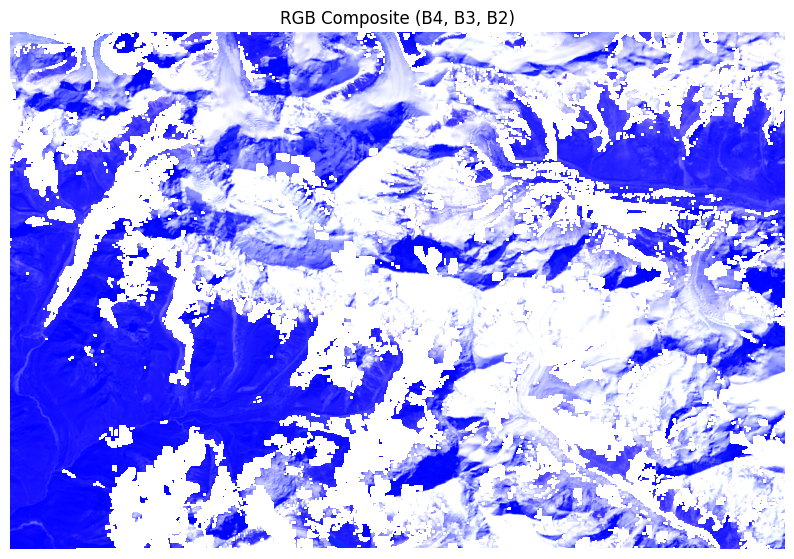

In [3]:
import rasterio
import matplotlib.pyplot as plt
#directly plotted the raw band values without scaling or normalization.
with rasterio.open( "C:/Users/HP/Downloads/himalaya_image.tif") as src:
    image_data = src.read([4, 3, 2])  # SR_B4 (Red), SR_B3 (Green), SR_B2 (Blue)
    image_data = image_data.transpose((1, 2, 0))

    plt.figure(figsize=(10, 10))
    plt.imshow(image_data)
    plt.title('RGB Composite (B4, B3, B2)')
    plt.axis('off')
    plt.show()

In [4]:
import numpy as np
image_data = np.clip(image_data, 0, 0.3)  # Adjust range based on real values
print("Any NaNs?", np.isnan(image_data).any())


Any NaNs? True


percentile-based linear contrast stretch.

🧠 Why Percentiles?
Satellite images often have outliers — extremely bright (e.g., clouds) or dark (e.g., shadows) pixels that skew the minimum and maximum values.

If you stretched using the actual min and max values (0–255 or raw reflectance values), the stretch would be dominated by these outliers and most of the image would still look dull or washed out.

So instead of using actual min/max, you use the 2nd and 98th percentiles, which are more representative of the image’s core data.

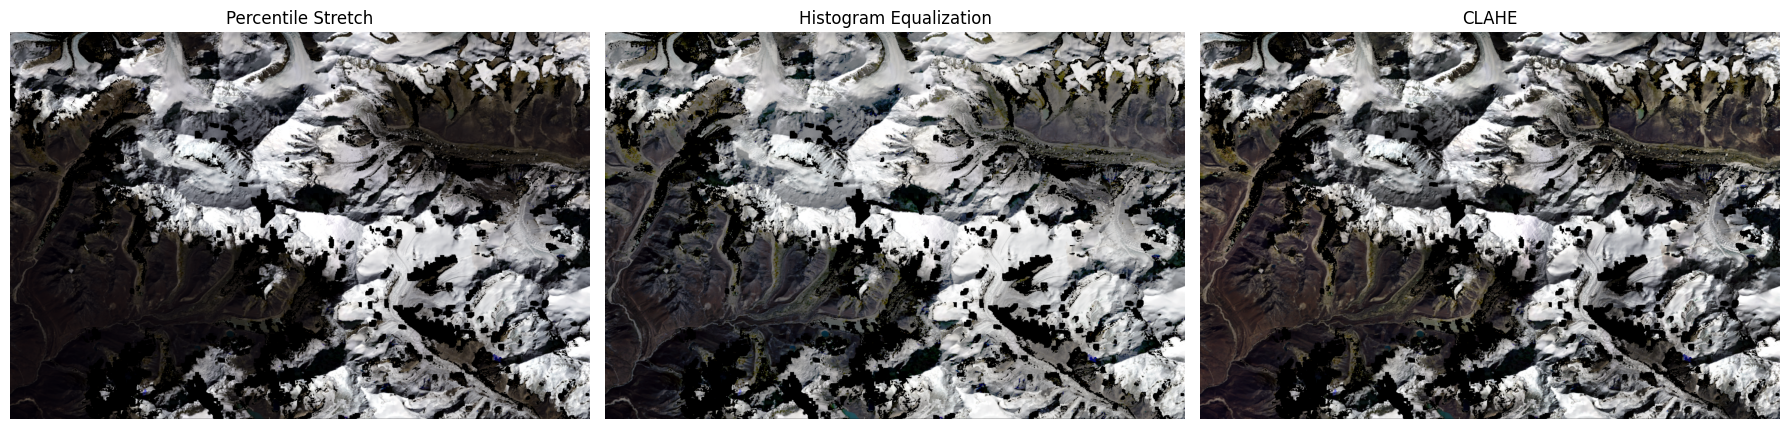

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2

file_path = "C:/Users/HP/Downloads/himalaya_image.tif"

with rasterio.open(file_path) as src:
    image_data = src.read([4, 3, 2])  # Red, Green, Blue
    image_data = image_data.transpose((1, 2, 0)).astype(np.float32)

nan_mask = np.any(np.isnan(image_data), axis=-1)
image_data[np.isnan(image_data)] = 0

# ========== Method 1: Percentile-based Contrast Stretch ==========
def stretch_band(band):
    p2, p98 = np.percentile(band[~nan_mask], (2, 98))
    return np.clip((band - p2) / (p98 - p2), 0, 1)

percentile_image = np.zeros_like(image_data)
for i in range(3):
    percentile_image[..., i] = stretch_band(image_data[..., i])
percentile_image[nan_mask] = 0

# ========== Method 2: Histogram Equalization ==========
# Convert image to uint8 and scale 0–255
scaled_image_8bit = (percentile_image * 255).astype(np.uint8)

# Apply histogram equalization channel-wise
hist_eq_image = np.zeros_like(scaled_image_8bit)
for i in range(3):
    hist_eq_image[..., i] = cv2.equalizeHist(scaled_image_8bit[..., i])
hist_eq_image = hist_eq_image.astype(np.float32) / 255
hist_eq_image[nan_mask] = 0

# ========== Method 3: CLAHE ==========
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = np.zeros_like(scaled_image_8bit)
for i in range(3):
    clahe_image[..., i] = clahe.apply(scaled_image_8bit[..., i])
clahe_image = clahe_image.astype(np.float32) / 255
clahe_image[nan_mask] = 0

# ========== Display All Methods ==========
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

titles = ['Percentile Stretch', 'Histogram Equalization', 'CLAHE']
images = [percentile_image, hist_eq_image, clahe_image]

for ax, img, title in zip(axs, images, titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [6]:
from scipy.ndimage import generic_filter

# Apply a mean filter to fill in small NaN gaps (not for analysis!)
def fill_nans(band):
    mask = np.isnan(band)
    filled = generic_filter(band, np.nanmean, size=5, mode='mirror')
    band[mask] = filled[mask]
    return band


In [7]:
tif_path = 'C:/Users/HP/Downloads/himalaya_image.tif'

# Read a single band (e.g., band 5)
with rasterio.open(tif_path) as src:
    original_band = src.read(5).astype('float32')  # Band 5 is often NIR

    # Convert 0s to NaNs if 0 is no-data in your dataset
    original_band[original_band == 0] = np.nan

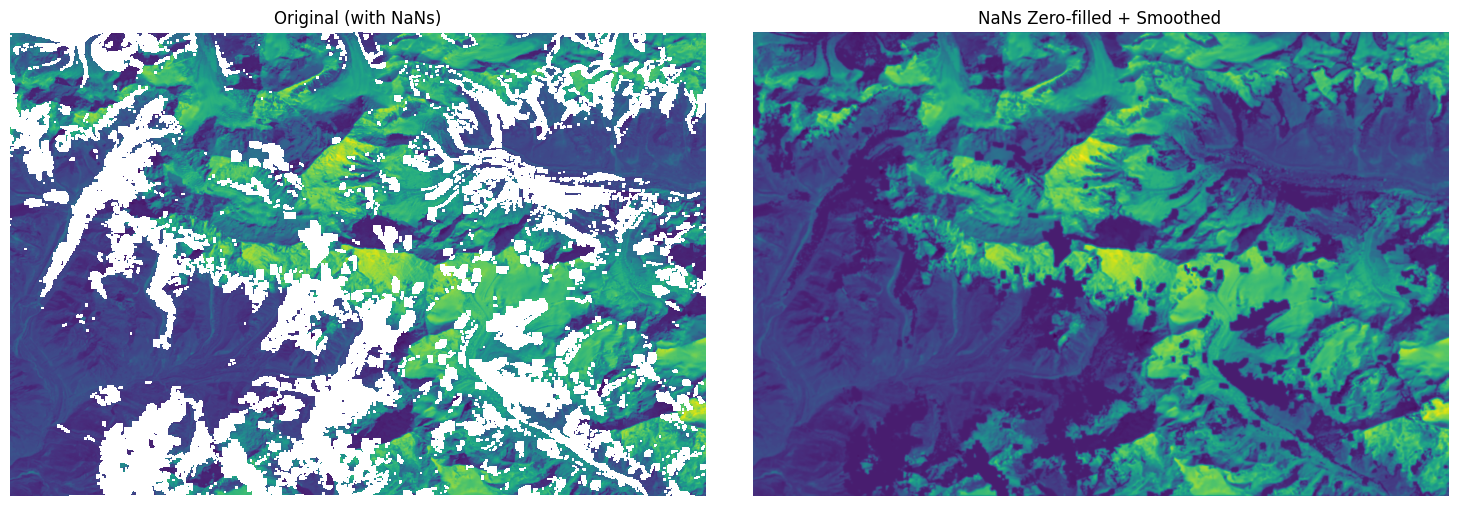

In [8]:
from scipy.ndimage import gaussian_filter

# Fill NaNs with zero temporarily
band_temp = np.nan_to_num(original_band, nan=0.0)

# Apply a soft blur (optional)
smoothed_band = gaussian_filter(band_temp, sigma=3)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_band, cmap='viridis')
plt.title("Original (with NaNs)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(smoothed_band, cmap='viridis')
plt.title("NaNs Zero-filled + Smoothed")
plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
print("Band 4 (Red) min:", image_data[:, :, 0].min(), "max:", image_data[:, :, 0].max())
print("Band 2 (Green) min:", image_data[:, :, 1].min(), "max:", image_data[:, :, 1].max())
print("Band 3 (Blue) min:", image_data[:, :, 2].min(), "max:", image_data[:, :, 2].max())

image_data = np.ma.masked_equal(image_data, 0)  # Masking NoData values (e.g., 0 or -9999)


Band 4 (Red) min: -0.1983225 max: 1.5241125
Band 2 (Green) min: -0.1999175 max: 1.5334074
Band 3 (Blue) min: 0.0 max: 64105.0


In [10]:
from osgeo import gdal
dataset = gdal.Open("C:/Users/HP/Downloads/himalaya_image.tif")

print(dataset.GetMetadata())
print("Number of Bands:", dataset.RasterCount)
print("GeoTransform:", dataset.GetGeoTransform())

{'AREA_OR_POINT': 'Area'}
Number of Bands: 19
GeoTransform: (86.799983822634, 8.983152841195215e-05, 0.0, 28.050164241217296, 0.0, -8.983152841195215e-05)


In [11]:
# making sure that the data is not entirely empty, hence loaded properly.
dataset.GetRasterBand(1).ReadAsArray()

array([[    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [29918. , 29918. , 29918. , ..., 42894.5, 42894.5, 42894.5],
       [29918. , 29918. , 29918. , ..., 42894.5, 42894.5, 42894.5],
       ...,
       [ 7297.5,  7304.5,  7304.5, ..., 15916. , 15916. , 13892.5],
       [ 7297.5,  7304.5,  7304.5, ..., 15916. , 15916. , 13892.5],
       [ 7297.5,  7304.5,  7304.5, ..., 12105.5, 12105.5, 12647.5]])

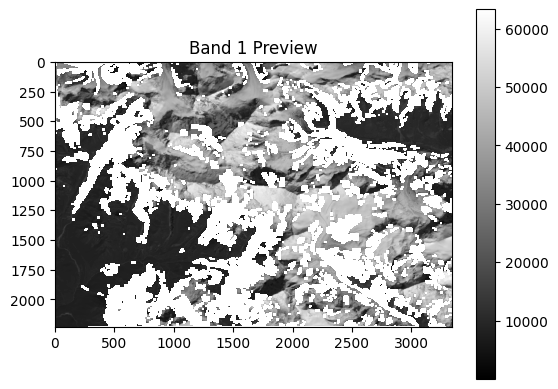

In [12]:
#visualization of single band from a satellite using graysclae
import matplotlib.pyplot as plt
#reads the first band (Band 1) of your satellite image into a NumPy array.
band_array = dataset.GetRasterBand(1).ReadAsArray()
plt.imshow(band_array, cmap='gray')
plt.title("Band 1 Preview")  #coastal and aerosol band
plt.colorbar()
plt.show()

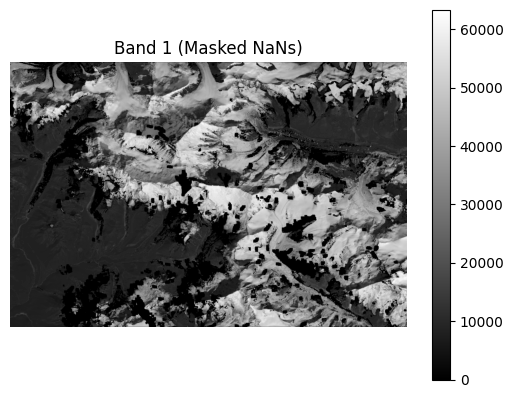

In [13]:
masked_band = np.nan_to_num(band_array, nan=0)

plt.imshow(masked_band, cmap='gray')
plt.title("Band 1 (Masked NaNs)")
plt.colorbar()
plt.axis("off")
plt.show()


Bright white regions: High reflectance — likely snow, ice, or clouds.

Darker gray areas: Lower reflectance — probably vegetation, water, or shadowed terrain.

Highly textured zones: Indicate mountainous relief — fitting since this is a Himalaya region image.

Missing/white blotches: Could be NaNs or saturated areas



In [ ]:
import numpy as np
np.nanmax(dataset.GetRasterBand(1).ReadAsArray())

In [ ]:
# Printing the Meta-Data In Detail
with rasterio.open("C:/Users/HP/Downloads/himalaya_image.tif") as src:
    print(f"Number of Bands: {src.count}")
    for band in range(1, src.count + 1):
        print(f"Band {band}: {src.descriptions[band - 1]}")

## ✅ What This Metadata Means

Here’s a quick breakdown of some important bands:

---

### 📊 Surface Reflectance (SR) Bands
- `SR_B1` to `SR_B7`: These are reflectance bands in different wavelengths (e.g., Blue, Green, Red, NIR, SWIR, etc.).
- **Useful for:** Vegetation indices (e.g., NDVI), snow detection, and land cover classification.

---

### 🌫️ Aerosol Quality
- `SR_QA_AEROSOL`: Quality assessment for aerosol content.
- **Useful for:** Detecting and correcting cloud or haze interference.

---

### 🌡️ Surface Temperature (ST) Bands
- `ST_B10`: Landsat thermal band used for land surface temperature.
- `ST_ATRAN` to `ST_URAD`: Intermediate parameters for atmospheric correction, emissivity, and radiance calculations.

---

### 🧼 Quality Assessment (QA) Bands
- `ST_QA`, `QA_PIXEL`, `QA_RADSAT`: Provide quality flags such as cloud cover, pixel saturation, etc.
- **Useful for:** Masking bad or unreliable pixels before conducting analysis.

---

This information is crucial for selecting the right bands for analysis and ensuring data quality during processing.


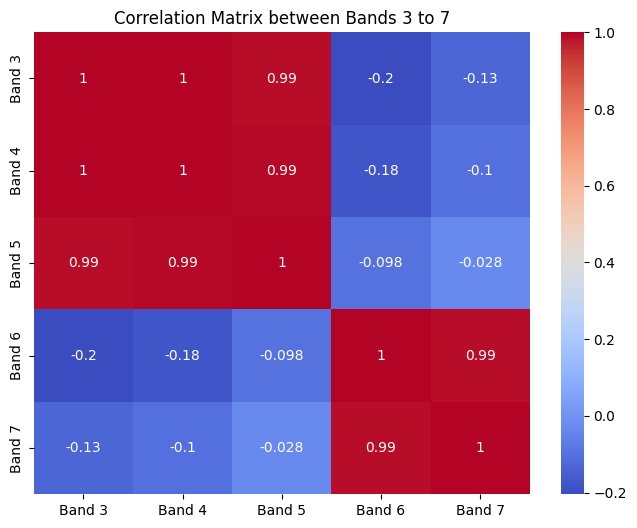

In [14]:
# Here, there are several Nan values because of these reasons:
# Satellite imagery can have NaN values in regions affected by clouds, cloud shadows, or other atmospheric disturbances where reflectance values
# cannot be accurately measured.
# Some pixels may represent areas where no data is available (e.g., out of the image bounds, in remote regions, or where the sensor failed to collect data).
# Hence, it is in best interest to replace these NaN values by just zero for simplicity of computation and not some other values because replacing NaN
# values with arbitrary values (e.g., zero or the mean of surrounding pixels) introduces bias. It distorts the actual reflectance data and can affect
# any further analysis, such as classification, index calculation (like NDSI or NDVI), or any machine learning model.

# Plotting heatmap correlation matrix, to see relation between multiple bands, some pairs like 6-7, 3-5, 4-5 seem to be highly correlated.
import seaborn as sns
with rasterio.open(file_path) as src:
    band_3 = src.read(3)
    band_4 = src.read(4)
    band_5 = src.read(5)
    band_6 = src.read(6)
    band_7 = src.read(7)

band_3 = np.nan_to_num(band_3, nan=0)
band_4 = np.nan_to_num(band_4, nan=0)
band_5 = np.nan_to_num(band_5, nan=0)
band_6 = np.nan_to_num(band_6, nan=0)
band_7 = np.nan_to_num(band_7, nan=0)

band_3_flat = band_3.flatten()
band_4_flat = band_4.flatten()
band_5_flat = band_5.flatten()
band_6_flat = band_6.flatten()
band_7_flat = band_7.flatten()


data = np.stack([band_3_flat, band_4_flat, band_5_flat, band_6_flat, band_7_flat])

correlation_matrix = np.corrcoef(data)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=["Band 3", "Band 4", "Band 5", "Band 6", "Band 7"],
            yticklabels=["Band 3", "Band 4", "Band 5", "Band 6", "Band 7"])
plt.title('Correlation Matrix between Bands 3 to 7')
plt.show()

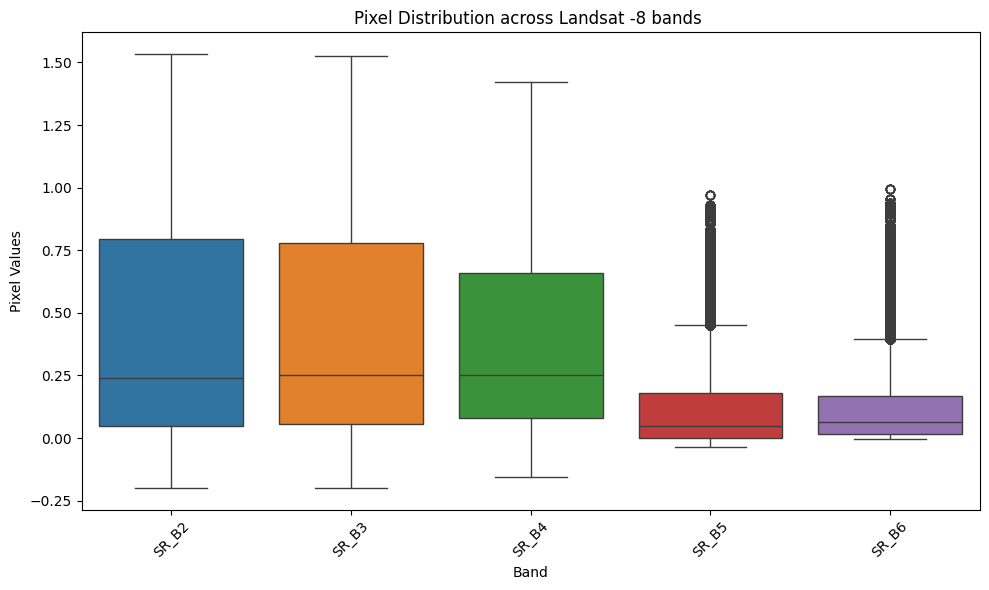

In [17]:
# Here, though there are outliers, but they may represent extreme temperature components like snow, so I am not removing the outliers.
# flattened arrays of pixel values for each respective band
all_bands = [band_3_flat, band_4_flat, band_5_flat, band_6_flat, band_7_flat]
band_names = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6']

plt.figure(figsize=(10, 6))
sns.boxplot(data=all_bands)
plt.xticks(np.arange(len(band_names)), band_names, rotation=45)
plt.title("Pixel Distribution across Landsat -8 bands ")
plt.xlabel("Band")
plt.ylabel("Pixel Values")
plt.tight_layout()
plt.show()

#High values in Green (SR_B3) and low values in SWIR1 (SR_B6) are signatures of snow/ice.
# these are often used to compute NDSI (Normalized Difference Snow Index):

## Background of NDSI

Defined by NASA/USGS and routinely used in processing data from Landsat, MODIS, and other Earth observation satellites.

It was introduced to automatically detect snow and ice using spectral characteristics.

NDSI is similar in concept to NDVI (Normalized Difference Vegetation Index), but instead of detecting vegetation, it targets snow and glaciers.

### 🔍 Why It Works
| **Band**  | **Role**                          | **Snow Response**                 |
|-----------|-----------------------------------|-----------------------------------|
| Green (Band 3) | Reflects visible green light        | Very high reflectance from snow  |
| SWIR1 (Band 6) | Short-Wave Infrared                 | Snow absorbs strongly → low reflectance |

Thus:

```mathematica
NDSI = (Green - SWIR1) / (Green + SWIR1)
     = (B3 - B6) / (B3 + B6)


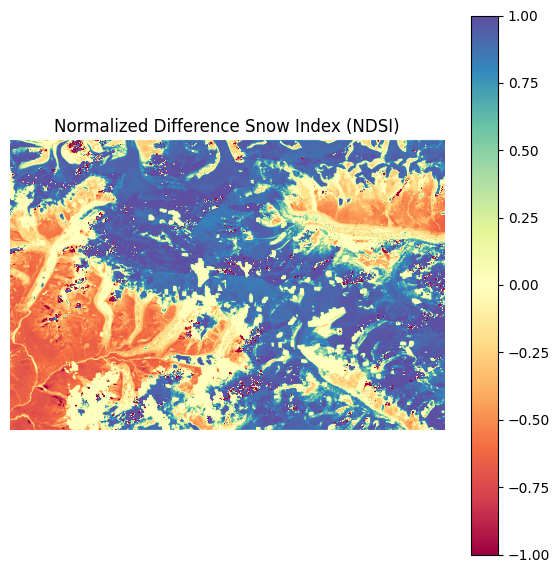

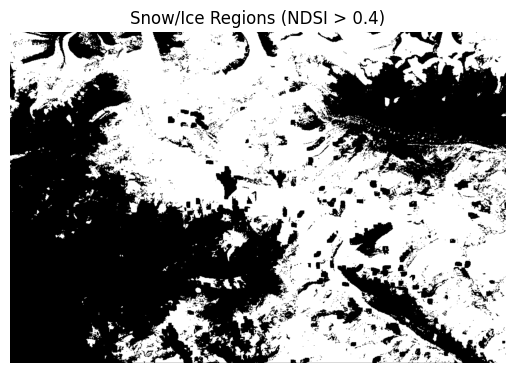

In [18]:
# Performing Feature Engineering, i.e. deriving a new feature named NDSI (Normalized Difference Snow Index) from Bands 3 and 6.
# NDSI is typically used to detect snow and ice, as these features often have a high reflectance in the Green band and
# a lower reflectance in the SWIR bands, which yields positive NDSI values

# NDSI = (band_3 - band_6) / (band_3 + band_6)
band_3 = band_3.astype(np.float32)
band_6 = band_6.astype(np.float32)

ndsi_denom = band_3 + band_6
ndsi_denom[ndsi_denom == 0] = 1e-5  # or use np.where()

NDSI = (band_3 - band_6) / ndsi_denom
# Plot NDSI
plt.figure(figsize=(7, 7))
plt.imshow(NDSI, cmap='Spectral', vmin=-1, vmax=1)
plt.title('Normalized Difference Snow Index (NDSI)')
plt.colorbar()
plt.axis('off')
plt.show()

snow_mask = NDSI > 0.4
plt.imshow(snow_mask, cmap='gray')
plt.title('Snow/Ice Regions (NDSI > 0.4)')
plt.axis('off')
plt.show()

# Can be used to estimate glacier area, track retreat/advance over time.

# Crucial for change detection, masking, and visualizations

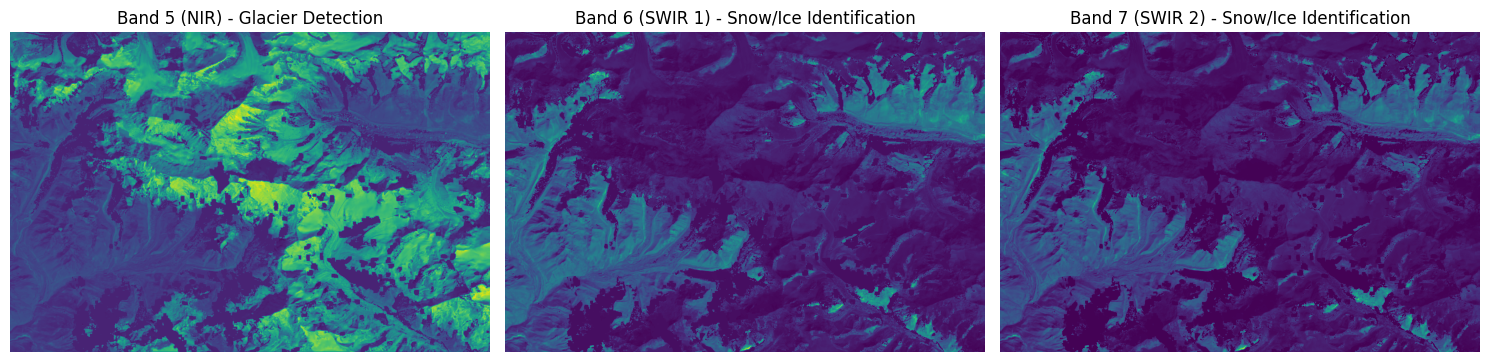

In [19]:
# Plotting band 5, 6 and 7.
# NIR (Band-5)  is useful for vegetation monitoring, SWIR1 (Band-6) is sensitive to moisture content, and wet surfaces such as soil, vegetation, or
# water tend to reflect differently in this band. SWIR2 (Band-7) is important for detecting moisture in soil and vegetation, as well as for
# distinguishing water from other land covers.
file_path = "C:/Users/HP/Downloads/himalaya_image.tif"

with rasterio.open(file_path) as src:
    band_5 = src.read(5)  # NIR (Near Infrared) vegetation monitoring and detecting snow/ice in some contexts.
    band_6 = src.read(6)  # SWIR 1
    band_7 = src.read(7)  # SWIR 2

band_5 = np.nan_to_num(band_5, nan=0)
band_6 = np.nan_to_num(band_6, nan=0)
band_7 = np.nan_to_num(band_7, nan=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(band_5)
axes[0].set_title('Band 5 (NIR) - Glacier Detection')
axes[0].axis('off')

axes[1].imshow(band_6)
axes[1].set_title('Band 6 (SWIR 1) - Snow/Ice Identification')
axes[1].axis('off')


axes[2].imshow(band_7)
axes[2].set_title('Band 7 (SWIR 2) - Snow/Ice Identification')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Min value of NDSI being -1.0:
# This suggests that in some areas, the difference between the Green band (Band 3) and the SWIR band (Band 6) is negative, and
# the reflectance in the SWIR band is much higher than in the Green band. The minimum value of -1.0 implies that the Green band is
# extremely small or close to zero compared to the SWIR band in these areas.
# Max value of 0.0:
# The maximum value of 0.0 suggests that in all of the image, there are no areas where the Green reflectance exceeds the SWIR reflectance to the
# point that the result is positive.
# Mean of -0.67:
# A mean value of -0.67 indicates that, on average, the Green reflectance is significantly lower than the SWIR reflectance.
# This is usually expected for non-snow/ice-covered areas (e.g., forests, urban areas), where the SWIR reflectance is generally higher than
# the Green reflectanc

NDSI = np.nan_to_num(NDSI, nan=0)
print("NDSI min:", NDSI.min(), "max:", NDSI.max(), "mean:", NDSI.mean())

In [ ]:
band_3_normalized = (band_3 - np.min(band_3)) / (np.max(band_3) - np.min(band_3))
band_6_normalized = (band_6 - np.min(band_6)) / (np.max(band_6) - np.min(band_6))


In [ ]:
NDSI = (band_3_normalized - band_6_normalized) / (band_3_normalized + band_6_normalized)
NDSI = np.nan_to_num(NDSI, nan=0)  # Replace NaN values with 0
print("NDSI min:", NDSI.min(), "max:", NDSI.max(), "mean:", NDSI.mean())


In [ ]:
snow_mask = NDSI > 0.3  # Snow/Ice areas
plt.imshow(snow_mask, cmap='gray')
plt.title('Snow/Ice Mask')
plt.axis('off')
plt.show()


In [ ]:
# Check NDSI values in specific regions
print("NDSI values in snow/ice regions:", NDSI[snow_mask])


In [ ]:
with rasterio.open(file_path) as src:
    print(src.profile)  # This will print the metadata of the image


In [24]:
snow_pixel_count = np.sum(snow_mask)
print(f"Number of snow/ice pixels: {snow_pixel_count}")


Number of snow/ice pixels: 3900316


In [25]:
from math import cos, radians

# Latitude of your image (you can adjust this if you know the region's average latitude)
latitude = 28.05  # from the affine transform (latitude at the center of the image)

# Convert degree resolution to meters
deg_to_meters = 111000  # 1 degree of latitude = 111 km (approx.)

# Pixel size in meters for latitude and longitude
pixel_size_x_meters = 8.98e-5 * deg_to_meters * cos(radians(latitude))  # For longitude
pixel_size_y_meters = 8.98e-5 * deg_to_meters  # For latitude

print(f"Pixel Size in X (meters): {pixel_size_x_meters}")
print(f"Pixel Size in Y (meters): {pixel_size_y_meters}")


Pixel Size in X (meters): 8.796957945228137
Pixel Size in Y (meters): 9.9678


In [26]:
# Calculate pixel area in km²
pixel_area_km2 = abs(pixel_size_x_meters * pixel_size_y_meters) / 1e6  # Convert m² to km²

# Recalculate snow area based on pixel count
snow_area_manual = snow_pixel_count * pixel_area_km2
print(f"Manually Calculated Snow/Ice Area: {snow_area_manual:.2f} km²")


Manually Calculated Snow/Ice Area: 342.00 km²


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13037467002868652..1.0].


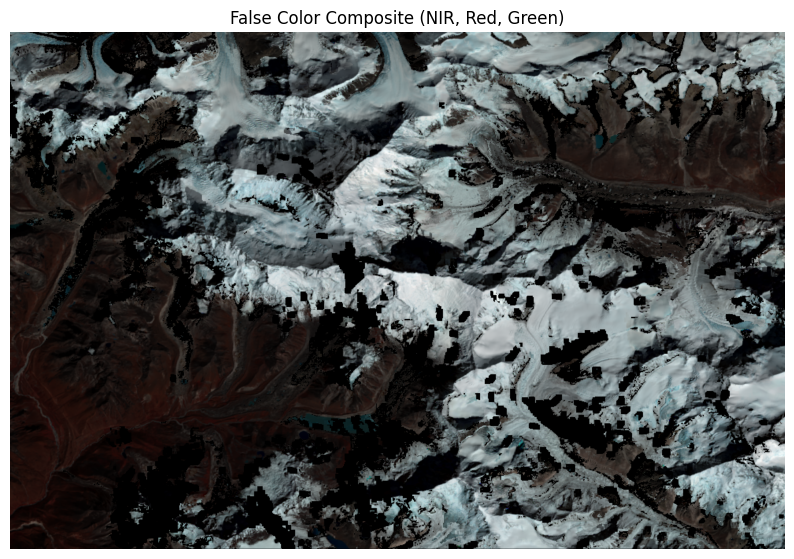

In [20]:
# Using the three bands to plot an RGB image of glacier characteristics measured over 2 months
band_5_norm = band_5 / band_5.max()
band_4_norm = band_4 / band_4.max()
band_3_norm = band_3 / band_3.max()
# each band is normalized by dividing with its max so all values are brought to 0 to 1;
rgb_image = np.stack((band_5_norm, band_4_norm, band_3_norm), axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("False Color Composite (NIR, Red, Green)")
plt.axis('off')
plt.show()

A false color composite is an image where we assign colors (Red, Green, Blue) to spectral bands that do not correspond to their natural color wavelengths. It’s essentially "color re-mapping" to highlight specific features that are hard to see in natural color images.

Band 5 (NIR):

Vegetation strongly reflects NIR → appears bright red in false color.

Snow and ice also reflect NIR → appear bright.

Water absorbs NIR → appears dark.

Band 4 (Red):

Good for detecting vegetation health.

Differentiates between urban and natural areas.

Band 3 (Green):

Helps provide contrast to other features.

Completes the RGB composite for smoother visuals.

Purpose of this Visualization:
False Color Composite: By using NIR as the red channel, red as the green channel, and green as the blue channel, you can better highlight certain characteristics, especially for vegetation and glacier identification. The NIR band (Band 5) is particularly useful in identifying water bodies, vegetation, and snow-covered areas, as they reflect significantly different in the NIR band compared to visible light.

In glacier-related imagery, this false-color composite can help you distinguish between ice, water, and vegetation. The NIR band will show up as red, making snow and ice more prominent in the image.

Significance:
By visualizing the data in this way, you can visually assess the glacier characteristics over time, such as glacier ice coverage, snow extent, and other land features that can help in studying glacier retreat or other environmental changes.

In [27]:
import ee

# Initialize Earth Engine
ee.Initialize()

# Define ROI: Approximate bounding box around Mount Everest
roi = ee.Geometry.Rectangle([86.5, 27.5, 87.5, 28.5])

# Display basic info
print("ROI defined for Mount Everest region.")



ROI defined for Mount Everest region.


In [28]:
# Define a function to filter and preprocess Landsat collections
def get_landsat_image(year, start_month=6, end_month=9):
    start_date = f"{year}-{start_month:02d}-01"
    end_date = f"{year}-{end_month:02d}-30"
    
    if year <= 2011:
        collection = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")  # Landsat 5
    elif year <= 2013:
        collection = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")  # Landsat 7
    elif year <= 2021:
        collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")  # Landsat 8
    else:
        collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")  # Landsat 9

    filtered = collection \
        .filterBounds(roi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
        .median()  # Composite to reduce cloud noise

    print(f"{year} image filtered and preprocessed.")
    return filtered.clip(roi)

# Fetch images for selected years
years = [1989, 2000, 2010, 2020, 2023]
images = {year: get_landsat_image(year) for year in years}


1989 image filtered and preprocessed.
2000 image filtered and preprocessed.
2010 image filtered and preprocessed.
2020 image filtered and preprocessed.
2023 image filtered and preprocessed.


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for LANDSAT/LT05/C01/T1_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/reference/removed_datasets#landsat_collection_1

  warnings.warn(warning, category=DeprecationWarning)
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for LANDSAT/LC08/C01/T1_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/reference/removed_datasets#landsat_collection_1

  warnings.warn(warning, category=DeprecationWarning)


In [29]:
import ee
import geemap

# Authenticate & initialize
ee.Authenticate()
ee.Initialize()

# Define Himalayas region (you can refine this polygon later)
himalayas = ee.Geometry.Polygon([
    [[75.0, 35.5], [75.0, 26.5], [90.5, 26.5], [90.5, 35.5]]
])

# Create map and center over Himalayas
Map = geemap.Map()
Map.centerObject(himalayas, 6)
Map.addLayer(himalayas, {}, 'Himalayas ROI')
Map


Map(center=[31.158894718862395, 82.75], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

In [30]:
#Filter Landsat 8 Surface Reflectance data
collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
   .filterBounds(roi) \
   .filterDate('2015-01-01', '2024-12-31') \
   .filter(ee.Filter.lt('CLOUD_COVER', 10))  # can relax to 20 if needed ( cloud cover is less than 10%)

#Just checking how many images we get
print('Number of images:', collection.size().getInfo())


Number of images: 259


In [31]:
# Make sure roi is defined as your desired region (e.g., Himalayas)
roi = ee.Geometry.Rectangle([76.0, 26.0, 92.0, 36.0])  # example coordinates for Himalayas

# Years you're interested in
years = list(range(2015, 2025))  # 2015 to 2024 inclusive

# Fetch images for each year
images = {year: get_landsat_image(year) for year in years}

# Optional: Count total number of filtered images (for info)
# This counts individual images BEFORE the median composite
collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")\
    .filterBounds(roi)\
    .filterDate('2015-01-01', '2024-12-31') \
    .filter(ee.Filter.lt('CLOUD_COVER', 10))

print("Number of Landsat 8 images (2015–2024):", collection.size().getInfo())



2015 image filtered and preprocessed.
2016 image filtered and preprocessed.
2017 image filtered and preprocessed.
2018 image filtered and preprocessed.
2019 image filtered and preprocessed.
2020 image filtered and preprocessed.
2021 image filtered and preprocessed.
2022 image filtered and preprocessed.
2023 image filtered and preprocessed.
2024 image filtered and preprocessed.
Number of Landsat 8 images (2015–2024): 7554


In [39]:
def scale_and_ndsi(image):
    # Apply scaling factor (SR = DN * 0.0000275 - 0.2)
    scaled = image.select(['SR_B3', 'SR_B6']) \
        .multiply(0.0000275).subtract(0.2)
    
    # Compute NDSI
    ndsi = scaled.expression(
        '(GREEN - SWIR1) / (GREEN + SWIR1)', {
            'GREEN': scaled.select('SR_B3'),
            'SWIR1': scaled.select('SR_B6')
        }).rename('NDSI')
    ndsi = ndsi.updateMask(ndsi.mask())
    return image.addBands(ndsi)

# Map over collection
collection_with_ndsi = collection.map(scale_and_ndsi)


Scaling the Reflectance Bands
Landsat Collection 2 Level-2 SR images store reflectance as scaled integers. To get reflectance values in the proper range (0–1), you use:

python
Copy
Edit
SR = DN * 0.0000275 - 0.2
You're applying this to:

SR_B3 → Green band

SR_B6 → SWIR1 band

✅ This is essential because NDSI needs reflectance values, not raw digital numbers (DNs).

2. Calculating NDSI
NDSI (Normalized Difference Snow Index) is then calculated using the scaled values:

python
Copy
Edit
NDSI = (Green - SWIR1) / (Green + SWIR1)
Where:

Green → high reflectance from snow

SWIR1 → low reflectance from snow

So:

High NDSI → snow/ice

Low/negative NDSI → non-snow (e.g., rock, vegetation)

📘 You rename the output band to NDSI, making it easy to filter or visualize later.

3. Add NDSI as a New Band

In [112]:
# Assuming 'collection_with_ndsi' is your existing collection with NDSI band

# 1. Create monthly median NDSI composites (NEW FUNCTION)
def make_monthly_image(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    monthly = collection_with_ndsi.filterDate(start, end).median()
    return monthly.set({'year': year, 'month': month, 'date': start.format('YYYY-MM')})

# 2. Generate the monthly image collection
months = []
for year in range(2015, 2025):
    for month in range(1, 13):
        months.append(make_monthly_image(year, month))

monthly_ndsi = ee.ImageCollection(months)


In [34]:
# Visualization and export (use only if not already defined)


# Function to unmask images (replace no-data with 0)
def unmask_image(image):
    return image.unmask(0)  # You can specify another value if needed

# Apply unmasking to the collection
collection_with_unmask = collection.map(unmask_image)

# Continue processing or export the collection as needed

gif_params = {
    'region': himalayas,  # or 'roi' if you defined it as such
    'dimensions': 600,
    'framesPerSecond': 1,
    'format': 'gif',
    'crs': 'EPSG:4326',
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white']
}

out_gif = 'ndsi_himalayas_timelapse.gif'

# 3. Export the time-lapse GIF
geemap.download_ee_video(monthly_ndsi.select('NDSI'), gif_params, out_gif)

# 4. Preview the GIF
geemap.show_image(out_gif)


Generating URL...
Please wait ...
HTTPSConnectionPool(host='earthengine.googleapis.com', port=443): Max retries exceeded with url: /v1/projects/1152484949/videoThumbnails/033ac8ba32f88167028ff985f4d7606a-6b1eb8d4590053090390976555edc23c:getPixels (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1147)')))


Output()